In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import json
import numpy as np
import os

In [26]:
scmap_str = json.loads(open("./DataPrep/scmap.json", "r").read())
scmap = {int(k): v for k, v in scmap_str.items()}
scmap[0xffff] = "NOSC"
scmap_r = {v: k for k, v in scmap.items()}

In [27]:
eval_fns = []
for f in os.listdir("./eval_out"):
    #print(f)
    if f.endswith(".eval"):
        eval_fns.append(f)

In [48]:
f1 = {}
cm = {}
count_plus = {}
count_plus_n = {}
#count_plus_all_typ = {}
for eval_fn in eval_fns:
    parts = eval_fn.split("_")
    cmd = parts[0]
    typ = parts[1]
    nfeat = int(parts[2])
    blur = int(parts[3])
    
    if cmd not in f1.keys():
        f1[cmd] = {}
        cm[cmd] = {}
        count_plus[cmd] = {}
        count_plus_n[cmd] = {}
    if typ not in f1[cmd].keys():
        f1[cmd][typ] = {}
        cm[cmd][typ] = {}
        count_plus[cmd][typ] = {}
        count_plus_n[cmd][typ] = {}
    if blur not in f1[cmd][typ].keys():
        f1[cmd][typ][blur] = {}
        cm[cmd][typ][blur] = {}
        count_plus[cmd][typ][blur] = {}
        count_plus_n[cmd][typ][blur] = {}
    if nfeat not in count_plus[cmd][typ][blur].keys():
        count_plus[cmd][typ][blur][nfeat] = {}
        count_plus_n[cmd][typ][blur][nfeat] = {}
    
    ev = pickle.load(open(os.path.join("./eval_out", eval_fn), "rb"))
    sc2key = ev["sc2key"]
    key2sc = ev["key2sc"]
    cf_matrix = ev["cf_matrix"]
    mkey = ev["mkey"]
    key = ev["key"]
    y_pred = ev["y_pred"]
    y_base = ev["y_base"]
    class_rep = ev["class_rep"]
    sc_count_pred = ev["sc_count_pred"]
    sc_count_base = ev["sc_count_base"]
    
    for key_id, count in sc_count_pred.items():
        #sc_id = key2sc[key_id]
        sc_id = key_id
        #sc = sc_id
        sc = scmap[sc_id]
        if sc == 'NOSC':
            continue
        #sc = scmap_r[sc]
        if sc not in count_plus[cmd][typ][blur][nfeat].keys():
            count_plus[cmd][typ][blur][nfeat][sc] = 0.0
            count_plus_n[cmd][typ][blur][nfeat][sc] = 0
        try:
            count_plus[cmd][typ][blur][nfeat][sc] += class_rep[sc]['f1-score']
        except:
            continue
        #count_plus_n[cmd][typ][blur][nfeat][sc] += count
        if sc not in sc_count_base.keys():
            count_plus_n[cmd][typ][blur][nfeat][sc] += count
        elif count > sc_count_base[sc]:
            count_plus_n[cmd][typ][blur][nfeat][sc] += (count - sc_count_base[sc])
            
    f1[cmd][typ][blur][nfeat] = class_rep['micro avg']['f1-score']
    #print(eval_fn)
    #print(class_rep['micro avg']['f1-score'])
    #f1[cmd][typ][blur][nfeat] = class_rep['weighted avg']['f1-score']
    #print(cmd)
    cm[cmd][typ][blur][nfeat] = cf_matrix

In [50]:
cf_matrix = cm['cat']['pr'][0][128]
print(cf_matrix[12])
print(cf_matrix[-1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.56328234e-05 1.11265647e-04
 5.56328234e-05 1.11265647e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.99666203e-01]


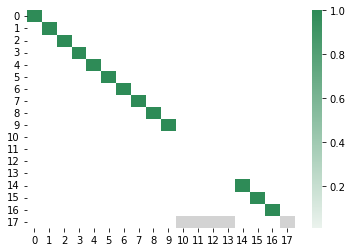

In [55]:
cf_matrix = cm['cat']['pr'][0][128]

#for x in range(len(cf_matrix)):
#    if sum(cf_matrix[x]) == 0.0:
#        cf_matrix[x][-1] = np.nan
        
cf_matrix[-1][cf_matrix[-1]>0.000000001] = np.nan
cf_matrix[:,-1][cf_matrix[:,-1]>0.0000000001] = np.nan

cmap = sns.light_palette('seagreen', as_cmap=True)
cmap.set_bad('lightgray')
cmap.set_under('white')
sns.heatmap(cf_matrix, annot=False, cmap=cmap, vmin=0.01, vmax=1.0)
plt.show()

In [6]:
count_plus_blur_typ = {}
count_plus_blur_typ_n = {}
for cmd, typ_data in count_plus.items():
    for typ, typ_data in typ_data.items():
        for blur, nfeat_data in typ_data.items():
            if blur == 12:
                continue
            blurx = 100
            if blurx not in count_plus_blur_typ.keys():
                count_plus_blur_typ[blurx] = {}
                count_plus_blur_typ_n[blurx] = {}
            if typ not in count_plus_blur_typ[blurx].keys():
                count_plus_blur_typ[blurx][typ] = {}
                count_plus_blur_typ_n[blurx][typ] = {}
            for nfeat, data in nfeat_data.items():
                for sc, score in data.items():
                    if sc not in count_plus_blur_typ[blurx][typ].keys():
                        count_plus_blur_typ[blurx][typ][sc] = 0.0
                        count_plus_blur_typ_n[blurx][typ][sc] = 0
                    count_plus_blur_typ[blurx][typ][sc] += score
                    count_plus_blur_typ_n[blurx][typ][sc] += count_plus_n[cmd][typ][blur][nfeat][sc]

In [7]:
for blur, blur_data in count_plus_blur_typ_n.items():
    if blur == 12:
        continue
    for typ, data in blur_data.items():
        #sc_sorted = {k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}
        #sc_max = list(sc_sorted.keys())[:64]
        #print("%s blur:%d" % (typ, blur))
        #print("\t" + "\n\t".join(map(lambda t: "%8.2f %8d %s" % (count_plus_blur_typ[blur][typ][t], data[t], t), sc_max)))
        sc_filtered = {}
        sc_filtered_n = {}
        sc_zero = []
        for sc in data.keys():
            if count_plus_blur_typ[blur][typ][sc] != 0.0:
                continue
            sc_zero.append(sc)
            sc_filtered[sc] = count_plus_blur_typ[blur][typ][sc]
            sc_filtered_n[sc] = count_plus_blur_typ_n[blur][typ][sc]
        sc_zero.sort()
        sc_sorted = {k: v for k, v in sorted(sc_filtered_n.items(), key=lambda item: item[1], reverse=True)}
        sc_max = list(sc_sorted.keys())[:64]
        print("%s blur:%d" % (typ, blur))
        print("\t" + "\n\t".join(map(lambda t: "%8.2f %8d %s" % (count_plus_blur_typ[blur][typ][t], data[t], t), sc_max)))
        print(list(sc_sorted.keys())[:32])
        print(list(map(lambda t: scmap_r[t], list(sc_sorted.keys())[:32])))

pr blur:100
	    0.00       94 sys_getpgid
	    0.00       11 sys_munlockall
	    0.00        0 sys_newfstatat
	    0.00        0 sys_faccessat
	    0.00        0 sys_kcmp
	    0.00        0 sys_bpf
	    0.00        0 sys_openat
	    0.00        0 sys_set_robust_list
	    0.00        0 sys_getrandom
	    0.00        0 sys_lgetxattr
	    0.00        0 sys_utimensat
	    0.00        0 sys_utimes
	    0.00        0 sys_sendmmsg
	    0.00        0 sys_readlinkat
	    0.00        0 sys_name_to_handle_at
	    0.00        0 sys_clock_gettime
	    0.00        0 sys_linkat
	    0.00        0 sys_epoll_create
	    0.00        0 sys_accept4
	    0.00        0 sys_pipe2
	    0.00        0 sys_mq_unlink
['sys_getpgid', 'sys_munlockall', 'sys_newfstatat', 'sys_faccessat', 'sys_kcmp', 'sys_bpf', 'sys_openat', 'sys_set_robust_list', 'sys_getrandom', 'sys_lgetxattr', 'sys_utimensat', 'sys_utimes', 'sys_sendmmsg', 'sys_readlinkat', 'sys_name_to_handle_at', 'sys_clock_gettime', 'sys_linkat', 'sys_epoll_c

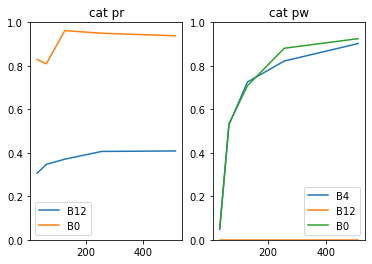

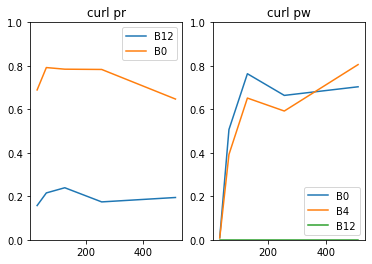

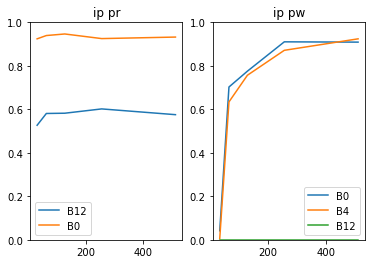

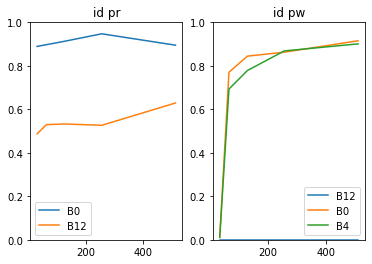

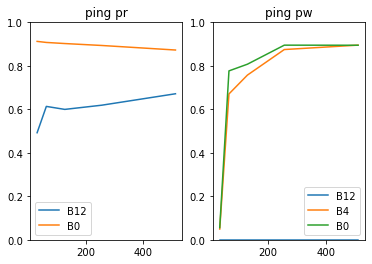

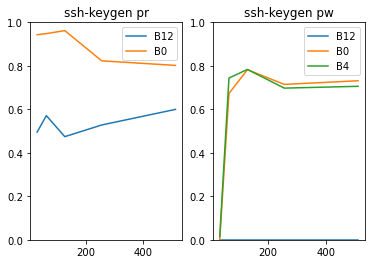

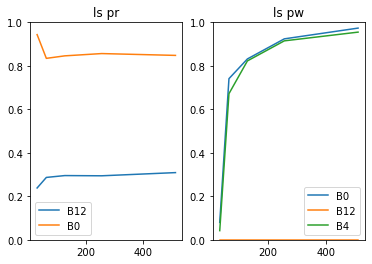

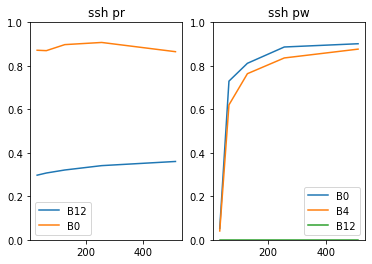

In [8]:
for cmd, typ_data in f1.items():
    #print(cmd)
    for typ, blur_data in typ_data.items():
        if typ == "pr":
            spid = 1
        else:
            spid = 2
        #print(typ)
        for blur, data in blur_data.items():
            #print(blur)
            n_feat_sorted = list(data.keys())
            n_feat_sorted.sort()
            f1_sorted = [data[k] for k in n_feat_sorted]
            #rint(f1_sorted)
            plt.subplot(1, 2, spid)
            plt.title("%s %s" % (cmd, typ))
            ax = plt.gca()
            ax.set_ylim([0.0, 1.0])
            ax.plot(n_feat_sorted, f1_sorted, label='B%d' % blur)
            ax.legend()
    plt.show()

In [ ]:

#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style(style='white')
sns.set_style('whitegrid')
for ei, eval_fn in enumerate(eval_fns):
    ev = pickle.load(open(eval_fn, "rb"))
    sc2key = ev["sc2key"]
    key2sc = ev["key2sc"]
    cf_matrix = ev["cm"]
    mkey = ev["mkey"]
    key = ev["key"]
    y_pred = ev["y_pred"]
    y_base = ev["y_base"]
    fig= plt.figure(1, figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111)
    cmap = sns.light_palette("dodgerblue", as_cmap=True)
    ax.set_facecolor('white')
    sns.heatmap(cf_matrix, annot=False, cmap=cmap, cbar=False, xticklabels=False, yticklabels=False)
    sns.set_style(style='white')
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('cm_%s.eps' % key, format='eps', bbox_inches = 'tight',
    pad_inches = 0)

In [ ]:
for ei, eval_fn in enumerate(eval_fns):
    ev = pickle.load(open(eval_fn, "rb"))
    sc2key = ev["sc2key"]
    key2sc = ev["key2sc"]
    cf_matrix = ev["cm"]
    mkey = ev["mkey"]
    key = ev["key"]
    y_pred = ev["y_pred"]
    y_base = ev["y_base"]
    
    nc_base = {}
    (bunique, bcounts) = np.unique(y_base, return_counts=True)
    for i in range(len(bunique)):
        nc_base[bunique[i]] = bcounts[i]
    nc_pred = {}
    (punique, pcounts) = np.unique(y_pred, return_counts=True)
    for i in range(len(punique)):
        nc_pred[punique[i]] = pcounts[i]
    with open("sc_%s.csv" % key, "w") as fd:
        fd.write("sc,cbase,cpfr,cpfw,cpfmr,cpfmw,cdma,\n")
        for sc, cnt in nc_base.items():
            cnt_pred = 0
            try:
                cnt_pred = nc_pred[sc]
            except:
                pass
            scname = scmap[key2sc[sc]]
            if scname == "NOSC":
                continue
            scname = scname.replace("sys_", "")
            scname = scname.replace("_", "\_")
            fd.write("%s,%d,%d,2,2,2,2,\n" % (scname, cnt, cnt_pred))

In [ ]:
fig, axs = plt.subplots(ncols=len(eval_fns),figsize=(32*len(eval_fns),28))
 
for ei, eval_fn in enumerate(eval_fns):
    ev = pickle.load(open(eval_fn, "rb"))
    sc2key = ev["sc2key"]
    key2sc = ev["key2sc"]
    cf_matrix = ev["cm"]
    mkey = ev["mkey"]
    key = ev["key"]
    y_pred = ev["y_pred"]
    y_base = ev["y_base"]
    
    if ei == len(eval_fns)-1:
        sns.heatmap(cf_matrix, annot=False, cmap='Blues', cbar=False, xticklabels=False, yticklabels=False, ax=axs[ei])
    else:
        sns.heatmap(cf_matrix, annot=False, cmap='Blues', cbar=False, xticklabels=False, yticklabels=False, ax=axs[ei])
    #ax[ei].tick_params(left=False, bottom=False)
    axs[ei].set_title(key)
plt.show()

In [ ]:
eval_fn = "ssh_0_pr_128_0_Random_Forrest.e692692caefa32cd31b19b1ea139f613.eval"

In [ ]:
ev = pickle.load(open(eval_fn, "rb"))

In [ ]:
sc2key = ev["sc2key"]
key2sc = ev["key2sc"]
cf_matrix = ev["cm"]
mkey = ev["mkey"]
key = ev["key"]
y_pred = ev["y_pred"]
y_base = ev["y_base"]

In [ ]:
sc_all = []
sc_all.extend(y_pred)
sc_all.extend(y_base)
sc_all = np.unique(sc_all)
sc_all.sort()
print(len(sc_all))
sc_labels = ["%d" % key2sc[t] for t in sc_all]
X_Tick_List = []
X_Tick_Label_List = []
for item in range (0,len(sc_all)):
    X_Tick_List.append(sc_all[item])
    #print(sc_all[item])
    try:
        X_Tick_Label_List.append(scmap[sc_all[item]])
    except:
        X_Tick_Label_List.append("%d/???" % sc_all[item])
#sns.set(font_scale=4)
ax = sns.heatmap(cf_matrix, annot=False, cmap='Blues')
#, xticklabels=X_Tick_Label_List, yticklabels=X_Tick_Label_List)

ax.set_title(mkey + " " + key);
#ax.set_xlabel('\nPredicted SC')
#ax.set_ylabel('Actual SC');
#plt.figure(figsize=(512, 512), 
#           dpi = 4096) 

#plt.rcParams['figure.figsize'] = [64, 128]

## Display the visualization of the Confusion Matrix.
plt.show()